# TFRecord Generation

In order to perform efficient data IO from disk <--> GPU, the TFRecord format is 
the preferred solution for TensorFlow. 

Documentation links: 
 1. [Detailed walk-thru](https://www.tensorflow.org/tutorials/load_data/tfrecord). 
 2. [TFRecordWriter](https://www.tensorflow.org/api_docs/python/tf/io/TFRecordWriter). 

## TODO/Diverging
 - [ ] Read in the data (per usual) -- don't use GPU!
	 - Use a decent number of frames (~100).
 	 - [ ] Ensure the data is good (make a visualization function).
 - [ ] Use `tf.io.serialize_tensor()` -> binary string representation.
 	 - [ ] Apply `Dataset.map()` to convert everything into binary data representations.
	 - [ ] Create a `Generator`, use it to create the `FlatMapDataset`.
 - [ ] Write the `FlatMapDataset` to a TFRecord file.
	 - [ ] See if you can use `tf.io.parse_tensor() to reconstruct...
 - [ ] Read the TFRecord back in (separate notebook).
 	 - [ ] Use `tf.io.parse_tensor()` to reconstruct tensor. 

## 0: Getting Data

In [27]:
## Import Box
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import sys 
import random
import pathlib
import itertools
import collections
import math

import tensorflow as tf 
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
# Some modules to display an animation using imageio.
import imageio

In [28]:
## Get some data 
# Utility imports  
sys.path.append("../src")
import video_loader as vl
import video_preprocess as vp 

## Meta/constants 
DATA_FOLDER = "../datasets/downloads"


# Control panel: Control data parameters, export location.
num_videos, num_frames = 16, 100
output_size = (120, 180)
patch_height = 16
patch_width = 16
patch_duration = 3

In [29]:
# Getting a list of the data
mp4_list = os.listdir(DATA_FOLDER)
mp4_list[:10]

['H1iWETEMl7c.mp4',
 'PmKbAgKa_V8.mp4',
 'zymMiwUtbqE.mp4',
 'jpeB76IUI9c.mp4',
 '5d-u6-UzbLk.mp4',
 'm-EUUkPuocE.mp4',
 '_LUKHNsSndk.mp4',
 'xp5sV_1SSKw.mp4',
 'JXtr3GbDYHY.mp4',
 '3SeOIr2YisM.mp4']

In [30]:
# Let's try making a generator 
def generate_video_tensors():
	for fname in mp4_list:
		retval = vl.get_single_video_tensor(os.path.join(DATA_FOLDER, fname), num_frames, output_size=output_size)
		# print(type(retval))
		if type(retval) == np.ndarray:
			yield retval

x = generate_video_tensors().__next__()
x.shape

cnt=0

for y in generate_video_tensors():
	cnt+=1
	if cnt == 4:
		x=y
		break

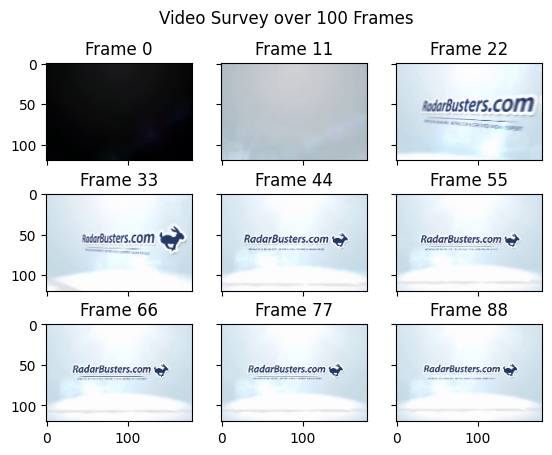

In [31]:
def show_nn_sq(video_tensor, n=3):
	n2 = n*n
	fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True)

	_nframes = video_tensor.shape[0]
	frame_inc = _nframes//(n2)

	for i in range(n):
		for j in range(n):
			full_idx = i*n + j

			axs[i,j].imshow(video_tensor[frame_inc*full_idx,:,:,:])
			axs[i,j].set_title(f"Frame {frame_inc*full_idx}")

	fig.suptitle(f"Video Survey over {_nframes} Frames")
			
show_nn_sq(x)

In [ ]:
x.shape # [nframes, [output_size], 3] -> [None, [output_size], 3]

In [32]:
full_dataset = tf.data.Dataset.from_generator(generate_video_tensors, output_signature=tf.TensorSpec(shape=x.shape, dtype=tf.float32))

## 1: Serializing Dataset

In [33]:
serialized_dataset = full_dataset.map(lambda x: tf.io.serialize_tensor(x))

In [34]:
for element in serialized_dataset:
	print(type(element))
	print(type(element.numpy()))
	break

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'bytes'>


In [35]:
filename = f"Test_TFRecords/full_{num_frames}frame_dataset.tfrecord"
print("Writing to file: ", filename)
# writer = tf.data.experimental.TFRecordWriter(filename)
writer = tf.io.TFRecordWriter(filename)

for element in tqdm(serialized_dataset, total=len(mp4_list)):
	feature_of_bytes = tf.train.Feature(bytes_list=tf.train.BytesList(value=[element.numpy()]))
	features_for_example = {
		'feature0': feature_of_bytes
	}
	example_prototype = tf.train.Example(
		features = tf.train.Features(feature = features_for_example)
	)
	writer.write(example_prototype.SerializeToString())

 35%|███▍      | 512/1472 [02:58<05:38,  2.84it/s][ERROR:1@1274.375] global /io/opencv/modules/videoio/src/cap.cpp (164) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /io/opencv/modules/videoio/src/cap_images.cpp:253: error: (-5:Bad argument) CAP_IMAGES: can't find starting number (in the name of file): ../datasets/downloads/subs in function 'icvExtractPattern'


 35%|███▍      | 513/1472 [02:58<05:33,  2.88it/s]

Unable to read in any frames. Check that the video path is valid.


100%|█████████▉| 1471/1472 [08:34<00:00,  2.86it/s]
